In [2]:
!python -c "import monai" || pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
%env CUDA_VISIBLE_DEVICES=0

2023-08-21 14:56:36.452428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 14:56:37.577320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

In [4]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 1, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 1, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 1, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 1, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 2, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 2, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 2, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 2, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

In [5]:
work_dir = "./helloworld_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

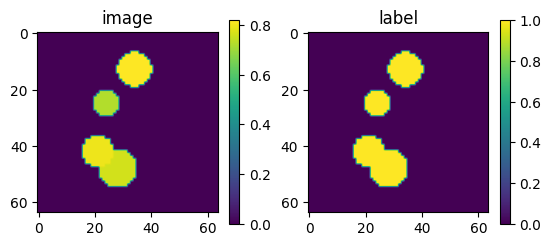

In [6]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["image"]))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["label"]))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title("image")
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title("label")
cbar = plt.colorbar(shrink=0.55)

In [7]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

2023-08-21 15:14:30,616 - INFO - AutoRunner using work directory ./helloworld_work_dir
2023-08-21 15:14:30,628 - INFO - Setting num_fold 3 based on the input datalist /content/helloworld_work_dir/sim_datalist.json.
2023-08-21 15:14:30,652 - INFO - Using user defined command running prefix , will override other settings


In [8]:
max_epochs = 2

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

In [9]:
runner.run()


2023-08-21 15:14:47,101 - INFO - Running data analysis...
2023-08-21 15:14:47,138 - INFO - Found 1 GPUs for data analyzing!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.array CropForeground.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


2023-08-21 15:14:58,036 - INFO - Writing data stats to /content/helloworld_work_dir/datastats.yaml.
2023-08-21 15:14:58,058 - INFO - Writing by-case data stats to /content/helloworld_work_dir/datastats_by_case.yaml, this may take a while.
2023-08-21 15:14:58,144 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/e01d67a.tar.gz


algo_templates.tar.gz: 96.0kB [00:00, 474kB/s]                             

2023-08-21 15:14:58,362 - INFO - Downloaded: /tmp/tmpse5_c27y/algo_templates.tar.gz
2023-08-21 15:14:58,363 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpse5_c27y/algo_templates.tar.gz.
2023-08-21 15:14:58,364 - INFO - Writing into directory: /content/helloworld_work_dir.


2023-08-21 15:14:58,602 - INFO - Generated:/content/helloworld_work_dir/dints_0
2023-08-21 15:14:58,666 - INFO - Generated:/content/helloworld_work_dir/segresnet_0
2023-08-21 15:14:58,702 - INFO - segresnet2d_0 is skipped! SegresNet2D is skipped due to median spacing of [1.0, 1.0, 1.0],  which means the dataset is not highly anisotropic, e.g. spacing[2] < 3*(spacing[0] + spacing[1])/2) .
2023-08-21 15:14:58,780 - INFO - Generated:/content/helloworld_work_dir/swinunetr_0
2023-08-21 15:14:58,827 - INFO - The keys num_warmup_epochs cannot be found in the /content/helloworld_work_dir/dints_0/configs/hyper_parameters.yaml for training. Skipped overriding key num_warmup_epochs.
2023-08-21 15:14:58,830 - INFO - ['python', '/content/helloworld_work_dir/dints_0/scripts/train.py', 'run', "--config_file='/content/helloworld_work_dir/dints_0/configs/hyper_parameters.yaml,/content/helloworld_work_dir/dints_0/configs/hyper_parameters_search.yaml,/content/helloworld_work_dir/dints_0/configs/network.y

Ensembling (rank 0)...:   0%|          | 0/2 [00:00<?, ?it/s]

config_file ['/content/helloworld_work_dir/swinunetr_0/configs/transforms_infer.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/transforms_train.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/network.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/transforms_validate.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/hyper_parameters.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/content/helloworld_work_dir/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './helloworld_work_dir/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  50%|█████     | 1/2 [00:07<00:07,  7.68s/it]

config_file ['/content/helloworld_work_dir/swinunetr_0/configs/transforms_infer.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/transforms_train.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/network.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/transforms_validate.yaml', '/content/helloworld_work_dir/swinunetr_0/configs/hyper_parameters.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/content/helloworld_work_dir/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './helloworld_work_dir/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...: 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]
2023-08-21 15:16:44,167 - INFO - Auto3Dseg pipeline is completed successfully.


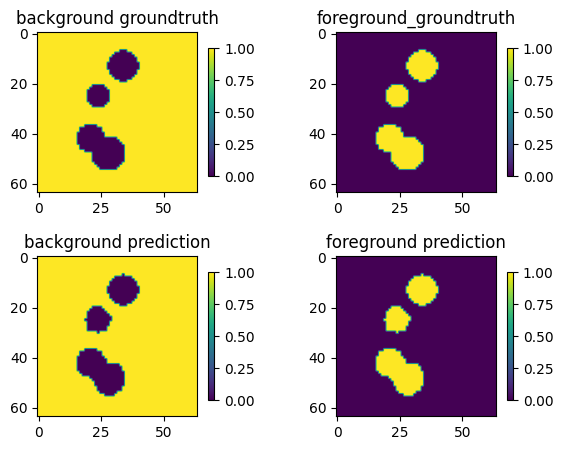

In [10]:
image_name = sim_datalist["testing"][0]["image"].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)

img_slice32 = lbl[32] == 0
label_slice32 = lbl[32] == 1
background_slice32 = pred[32, :, :, 0] if pred.ndim == 4 else pred[32] == 0
foreground_slice32 = pred[32, :, :, 1] if pred.ndim == 4 else pred[32] == 1

plt.subplot(2, 2, 1)
plt.imshow(img_slice32)
plt.title("background groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(label_slice32)
plt.title("foreground_groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(background_slice32)
plt.title("background prediction")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(foreground_slice32)
plt.title("foreground prediction")
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()